# 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from imblearn.combine import *
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("noshow.csv")

In [ ]:
df.tail()

In [3]:
region_weather = pd.read_csv("region_weather.csv")
region_weather.tail()

,region,temperature,time,weather
2171,CENTRO,14.905556,1.462493e+09,Clear
2172,SÃO BENEDITO,28.127778,1.465258e+09,Humid
2173,ITARARÉ,11.816667,1.465258e+09,Mostly Cloudy
2174,SANTA CLARA,9.900000,1.465258e+09,Partly Cloudy
2175,CENTRO,9.955556,1.465258e+09,Partly Cloudy


In [4]:
import time
region_weather.time = region_weather.time.apply(lambda x: time.strftime("%Y-%m-%d", time.localtime(int(x))))

### Age 범주형 변수로 바꾸기

In [5]:
df["Age_bin"] = "0"
df["Age_bin"][df.Age < 10] = "0s"
df["Age_bin"][(df.Age >= 10) & (df.Age < 20)] = "10s"
df["Age_bin"][(df.Age >= 20) & (df.Age < 30)] = "20s"
df["Age_bin"][(df.Age >= 30) & (df.Age < 40)] = "30s"
df["Age_bin"][(df.Age >= 40) & (df.Age < 50)] = "40s"
df["Age_bin"][(df.Age >= 50) & (df.Age < 60)] = "50s"
df["Age_bin"][(df.Age >= 60) & (df.Age < 70)] = "60s"
df["Age_bin"][(df.Age >= 70) & (df.Age < 80)] = "70s"
df["Age_bin"][(df.Age >= 80) & (df.Age < 90)] = "80s"
df["Age_bin"][df.Age >= 90] = "90s"

### 날짜형식 범주형 변수로 바꿔주기

In [6]:
df["Scheduled_date"] = df["ScheduledDay"].apply(lambda x: x[:10])
df['Scheduled_date'] = pd.to_datetime(df['Scheduled_date'])
df['Scheduled_time'] = df['ScheduledDay'].apply(lambda x: x[11:-1])
df['Scheduled_time'] = pd.to_timedelta(df['Scheduled_time'])
df['Appointment_date'] = df['AppointmentDay'].apply(lambda x: x[:10])
df['Appointment_date'] = pd.to_datetime(df['Appointment_date'])
df['Appointment_time'] = df['AppointmentDay'].apply(lambda x: x[11:-1])
df['Appointment_time'] = pd.to_timedelta(df['Appointment_time'])
df = df.drop(columns = "Appointment_time")

In [7]:
df["date_diff"] = df.Appointment_date - df.Scheduled_date

In [8]:
df.date_diff = df.date_diff.apply(lambda x: int(str(x).split("days")[0]))

### Handcap 범주형 변수로 바꾸기

In [9]:
df.Handcap = pd.Categorical(df.Handcap)

### Age가 음수이거나 date_diff가 음수인 데이터 빼주기

In [10]:
df = df[df.Age >= 0]

In [11]:
df = df[df.date_diff >= 0]

In [12]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age_bin,Scheduled_date,Scheduled_time,Appointment_date,date_diff
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No,50s,2016-05-03,09:15:35,2016-06-07,35
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No,50s,2016-05-03,07:27:33,2016-06-07,35
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,20s,2016-04-27,16:03:52,2016-06-07,41
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No,30s,2016-04-27,15:09:23,2016-06-07,41
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No,50s,2016-04-27,13:30:56,2016-06-07,41


In [13]:
region_weather.tail()

,region,temperature,time,weather
2171,CENTRO,14.905556,2016-05-06,Clear
2172,SÃO BENEDITO,28.127778,2016-06-07,Humid
2173,ITARARÉ,11.816667,2016-06-07,Mostly Cloudy
2174,SANTA CLARA,9.900000,2016-06-07,Partly Cloudy
2175,CENTRO,9.955556,2016-06-07,Partly Cloudy


In [14]:
region_weather.time = pd.to_datetime(region_weather.time)

In [15]:
df_sum = pd.merge(df, region_weather, how="inner", left_on=["Neighbourhood", "Appointment_date"], right_on=["region", "time"])

In [16]:
df_sum.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,No-show,Age_bin,Scheduled_date,Scheduled_time,Appointment_date,date_diff,region,temperature,time,weather
110515,7.469735e+14,5621289,F,2016-04-26T10:06:18Z,2016-06-06T00:00:00Z,65,NAZARETH,0,0,0,...,No,60s,2016-04-26,10:06:18,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110516,3.876254e+11,5621303,F,2016-04-26T10:06:48Z,2016-06-06T00:00:00Z,39,NAZARETH,0,0,0,...,Yes,30s,2016-04-26,10:06:48,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110517,5.881500e+12,5621251,M,2016-04-26T10:03:39Z,2016-06-06T00:00:00Z,65,NAZARETH,0,0,0,...,No,60s,2016-04-26,10:03:39,2016-06-06,41,NAZARETH,25.427778,2016-06-06,Humid
110518,9.255818e+13,5774386,M,2016-06-06T08:12:05Z,2016-06-06T00:00:00Z,59,AEROPORTO,0,0,0,...,No,50s,2016-06-06,08:12:05,2016-06-06,0,AEROPORTO,25.638889,2016-06-06,Humid
110519,3.489871e+11,5752392,M,2016-05-31T11:41:21Z,2016-06-02T00:00:00Z,36,ILHA DO BOI,0,0,0,...,No,30s,2016-05-31,11:41:21,2016-06-02,2,ILHA DO BOI,22.950000,2016-06-02,Mostly Cloudy


In [17]:
df_sum.groupby("No-show").mean()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff,temperature
No-show,,,,,,,,,,
No,1.476825e+14,5.681136e+06,37.790740,0.093905,0.204397,0.073839,0.030417,0.291341,8.754858,22.859089
Yes,1.467385e+14,5.652252e+06,34.317872,0.115533,0.169042,0.064085,0.030340,0.438469,15.835484,22.714594


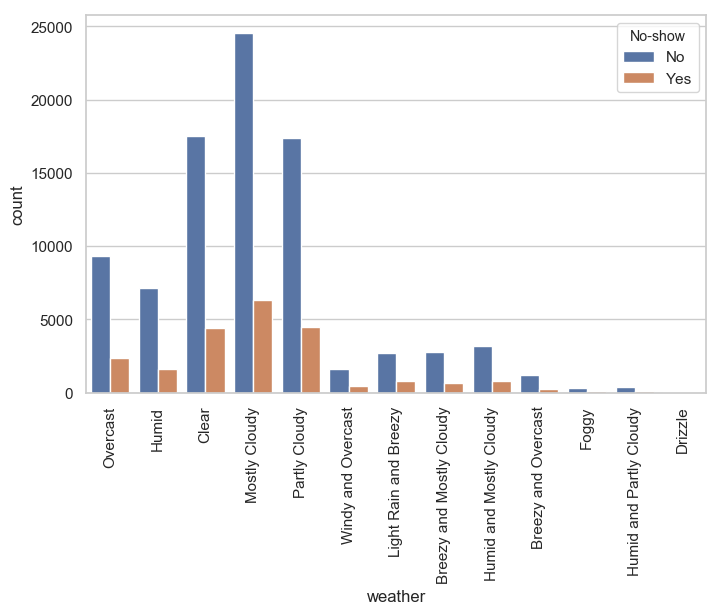

In [18]:
plt.xticks(rotation=90)
ax = sns.countplot(df_sum.weather, hue=df_sum["No-show"])

### countplot에서 height를 구해 날씨에 따른 No-show비율 보기

In [19]:
ls1 = [l.get_text() for l in ax.get_xticklabels()]

In [20]:
ls2 = [p.get_height() for p in ax.patches]

In [21]:
for i in range(13):
    print(ls1[i],": ",ls2[i+13] / (ls2[i] + ls2[i+13]))

Overcast :  0.2034750021292905
Humid :  0.18645227505987
Clear :  0.2009315919262033
Mostly Cloudy :  0.2051439862654271
Partly Cloudy :  0.20452364633310485
Windy and Overcast :  0.205666829506595
Light Rain and Breezy :  0.2194634703196347
Breezy and Mostly Cloudy :  0.19022534386889084
Humid and Mostly Cloudy :  0.1941747572815534
Breezy and Overcast :  0.17915531335149865
Foggy :  0.24056603773584906
Humid and Partly Cloudy :  0.20192307692307693
Drizzle :  0.1774193548387097


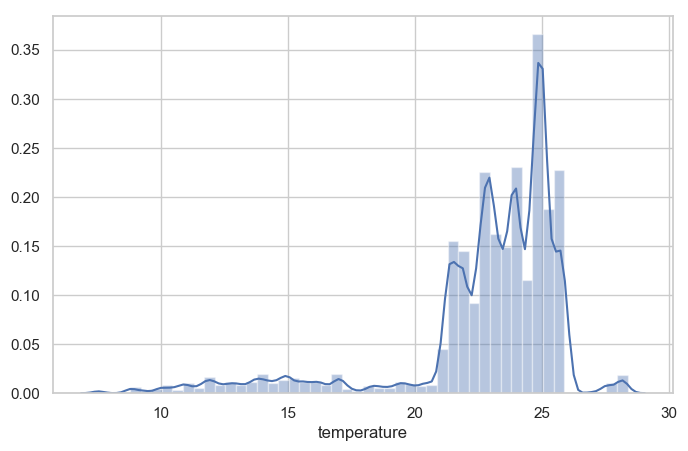

In [22]:
sns.distplot(df_sum.temperature)

### dfx와 dfy로 나눠주기

In [34]:
dfx = df_sum.drop(columns=["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Age", "No-show", "Scheduled_date", "Scheduled_time", "Appointment_date", "time", "region"], axis=1)
dfy = df_sum["No-show"]

In [24]:
dfx.tail()

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Age_bin,date_diff,temperature,weather
110515,F,NAZARETH,0,0,0,0,0,1,60s,41,25.427778,Humid
110516,F,NAZARETH,0,0,0,0,0,1,30s,41,25.427778,Humid
110517,M,NAZARETH,0,0,0,0,0,1,60s,41,25.427778,Humid
110518,M,AEROPORTO,0,0,0,0,0,0,50s,0,25.638889,Humid
110519,M,ILHA DO BOI,0,0,0,0,0,0,30s,2,22.950000,Mostly Cloudy


In [25]:
dfy.tail()

110515     No
110516    Yes
110517     No
110518     No
110519     No
Name: No-show, dtype: object

### one hot encoding 적용

In [ ]:
dfx = pd.get_dummies(dfx, drop_first=True)

In [ ]:
dfx.head()

### train과 test 데이터로 나누기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_train, y_train)

In [ ]:
model_sk = LogisticRegression().fit(X_samp, y_samp)

In [ ]:
# y_pred = model_sk.predict(X_test)
# set thresholds 0.3
y_pred = ["Yes" if x else "No" for x in (model_sk.predict_proba(X_test)[:,1] >= 0.6)]

In [ ]:
confusion_matrix(y_test, y_pred, labels=["Yes", "No"])

In [ ]:
recall = 4673 / (4673 + 2078)
fallout = 10674 / (10674 + 15731)
print("recall =", recall)
print("fallout =", fallout)

In [ ]:
print(classification_report(y_test, y_pred ))

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
model_sk.decision_function(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model_sk.decision_function(X_test), pos_label="Yes")
fpr, tpr, thresholds

In [ ]:
y_hat = model_sk.predict(X_test)
f_value = model_sk.decision_function(X_test)

df1 = pd.DataFrame(np.vstack([f_value, y_hat, y_test]).T,
                  columns=["f", "y_hat", "y"])
df1.sort_values("f", ascending=False).reset_index(drop=True)

In [ ]:
plt.plot(fpr, tpr, 'o-', label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

In [ ]:
auc(fpr, tpr)

In [ ]:
from sklearn.model_selection import validation_curve

In [ ]:
model_sk.get_params()

In [ ]:
param_range = np.logspace(-1, 0, 10)

In [ ]:
param_range

In [ ]:
%%time
train_scores, test_scores = \
validation_curve(LogisticRegression(), X_samp, y_samp,
                 param_name="C", param_range=param_range,
                 cv=10, scoring="accuracy", n_jobs=1)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with LogisticRegression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

# 변수 설명

In [ ]:
sns.distplot(df.Age)

In [ ]:
df_sum.dtypes

In [ ]:
age_se = df_sum.groupby(["Age_bin", "No-show"]).size()
age_se

In [ ]:
age_dic = {}
age_ls = [age_se[i+1] / (age_se[i] + age_se[i+1]) for i in range(0, 20, 2)]
for i in range(0, 20, 2):
    
    print(age_se.index.levels[0][i//2], ": ", age_se[i+1] / (age_se[i] + age_se[i+1]))

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(df.Neighbourhood)
ax.set_title("Neighbourbood")
plt.show()

In [ ]:
sns.countplot(df.Handcap)

In [ ]:
sns.countplot(df.Alcoholism)

In [ ]:
sns.countplot(df.Diabetes)

In [ ]:
sns.countplot(df.Hipertension)

In [ ]:
sns.countplot(df.Scholarship)

In [ ]:
a = df[["Gender", "No-show", "AppointmentID"]].groupby(["Gender", "No-show"]).agg('count')

In [ ]:
p1 = plt.bar(x=["Man", "Woman"], height=[7725, 14594], color='r')
p2 = plt.bar(x=["Man", "Woman"], height=[30962, 57246], bottom=[7725, 14594], color='b')
plt.legend((p1, p2), ("Yes", "No"))

In [ ]:
sns.countplot(df["No-show"], palette=['g','y'])

In [ ]:
sns.distplot(df["Age"])

In [ ]:
sns.distplot(df["Age"][df["No-show"] == "Yes"])
sns.distplot(df["Age"])
plt.legend(["Yes", "Total"])

In [ ]:
sns.distplot(df.date_diff)

In [ ]:
len(X_train), len(y_train)

### OLS

In [72]:
df_st = pd.concat([dfx, dfy], axis=1)

In [73]:
df_st = df_st.rename(columns={"No-show": "No_show"})

In [74]:
df_st.tail()

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Age_bin,date_diff,temperature,weather,No_show
110515,F,NAZARETH,0,0,0,0,0,1,60s,41,25.427778,Humid,No
110516,F,NAZARETH,0,0,0,0,0,1,30s,41,25.427778,Humid,Yes
110517,M,NAZARETH,0,0,0,0,0,1,60s,41,25.427778,Humid,No
110518,M,AEROPORTO,0,0,0,0,0,0,50s,0,25.638889,Humid,No
110519,M,ILHA DO BOI,0,0,0,0,0,0,30s,2,22.950000,Mostly Cloudy,No


In [75]:
df_st["No_show"][df_st["No_show"] == "Yes"] = 1
df_st["No_show"][df_st["No_show"] == "No"] = 0

In [76]:
df_st.No_show = df_st.No_show.astype('int')

In [116]:
df_st = pd.get_dummies(df_st)

In [117]:
df_st_train, df_st_test = train_test_split(df_st, test_size=0.3, random_state=0)

In [118]:
df_st_train.shape, df_st_test.shape

((77364, 118), (33156, 118))

In [179]:
X_st, y_st = SMOTEENN(random_state=0).fit_sample(df_st_train.drop(columns="No_show"), df_st_train["No_show"])

In [180]:
X_st.shape

(77252, 117)

In [181]:
df_st_train.tail()

,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,date_diff,temperature,No_show,Gender_F,Gender_M,...,weather_Drizzle,weather_Foggy,weather_Humid,weather_Humid and Mostly Cloudy,weather_Humid and Partly Cloudy,weather_Light Rain and Breezy,weather_Mostly Cloudy,weather_Overcast,weather_Partly Cloudy,weather_Windy and Overcast
21243,0,0,0,0,0,1,25.577778,1,0,1,...,0,0,0,0,0,0,0,0,0,0
45891,0,0,0,0,0,2,23.761111,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42613,0,0,0,0,1,21,22.666667,0,1,0,...,0,0,0,0,0,0,0,1,0,0
43567,0,0,0,0,1,24,21.827778,0,0,1,...,0,0,0,0,0,0,0,1,0,0
68268,0,1,0,0,0,5,21.238889,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [182]:
df_st_s = pd.DataFrame(X_st, columns=df_st_train.columns.drop("No_show"))

In [183]:
y_st.shape

(77252,)

In [184]:
df_st_s.shape

(77252, 117)

In [185]:
df_st_sy = pd.DataFrame(y_st)

In [202]:
df_f = pd.concat([df_st_s.drop(columns="temperature").astype('int'), df_st_s.temperature], axis=1)

In [204]:
model_med = sm.Logit(df_st_sy, df_f)

In [209]:
result_med = model_med.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 0.333709
         Iterations: 18
         Function evaluations: 27
         Gradient evaluations: 44
         Hessian evaluations: 18


In [210]:
print(result_med.summary())

                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:                77252
Model:                          Logit   Df Residuals:                    77136
Method:                           MLE   Df Model:                          115
Date:                Sun, 30 Dec 2018   Pseudo R-squ.:                  0.4833
Time:                        19:06:41   Log-Likelihood:                -25780.
converged:                       True   LL-Null:                       -49898.
                                        LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Scholarship                                  -0.1936      0.038     -5.154      0.000      -0.267      -0.120
Hipertension                          

In [211]:
train_ypred = result_med.predict(df_st_test.drop(columns="No_show"))

In [212]:
accuracy_score(train_ypred, df_st_test["No_show"])

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [154]:
model_med = sm.Logit.from_formula("No_show ~ Scholarship + Diabetes + Alcoholism +\
SMS_received + C(Age_bin) + date_diff + temperature + C(weather)", data=df_st_train)

PatsyError: Error evaluating factor: NameError: name 'Age_bin' is not defined
    No_show ~ Scholarship + Diabetes + Alcoholism +SMS_received + C(Age_bin) + date_diff + temperature + C(weather)
                                                                  ^^^^^^^^^^

In [153]:
result_med = model_med.fit()

AttributeError: 'Logit' object has no attribute 'filt'

In [151]:
print(result_med.summary())

                           Logit Regression Results                           
Dep. Variable:                No_show   No. Observations:                77364
Model:                          Logit   Df Residuals:                    77336
Method:                           MLE   Df Model:                           27
Date:                Sun, 30 Dec 2018   Pseudo R-squ.:                 0.04344
Time:                        18:50:00   Log-Likelihood:                -37151.
converged:                       True   LL-Null:                       -38838.
                                        LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -1.7117      0.088    -19.483      0.000      -1.884      -1.540
C(Age_bin)[T.10s]                         0.3589  

In [107]:
train_ypred = result_med.predict(df_st_test)

In [108]:
train_ypred_r = np.where(train_ypred > 0.2, 1, 0)

In [110]:
confusion_matrix(df_st_test["No_show"], train_ypred_r, labels=[1, 0])

array([[ 3995,  2756],
       [ 8691, 17714]])

In [112]:
print(classification_report(df_st_test["No_show"], train_ypred_r))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76     26405
           1       0.31      0.59      0.41      6751

   micro avg       0.65      0.65      0.65     33156
   macro avg       0.59      0.63      0.58     33156
weighted avg       0.75      0.65      0.69     33156



In [114]:
accuracy_score(df_st_test["No_show"], train_ypred_r)

0.6547532874894438

In [ ]:
test_ypred = result_med.predict(X_test)

In [ ]:
test_ypred_r = np.where(test_ypred > 0.2 ,1 ,0)

In [ ]:
a = confusion_matrix(y_test, test_ypred_r, labels=[1,0])
a

In [ ]:
print(classification_report(y_test, test_ypred_r))

In [ ]:
accuracy_score(y_test, test_ypred_r)

In [ ]:
result_med.pred_table()

In [ ]:
def test_score():
    df1 = pd.DataFrame(columns=["thresholds", "precision", "recall", "accuracy"])
    for i in np.linspace(0.1,0.9,9):
        test_ypred_r = np.where(test_ypred > i ,1 ,0)
        a = confusion_matrix(y_test, test_ypred_r, labels=[1,0])
        accur = accuracy_score(y_test, test_ypred_r)
        df1.loc[len(df1)] = [i, 
                  a[0][0] / (a[0][0] + a[1][0]),
                  a[0][0] / (a[0][0] + a[0][1]),
                  accur]
    return df1

In [ ]:
test_score()

## 비대칭 데이터 문제 해결 방법

OLS 포뮬러가 다른 패키지와 호환이 잘 안된다.

OLS 포뮬러로 처리해주는 것보다.

그냥 전처리 일일이 해주고 하는 것이 낫다.

In [ ]:
sns.distplot(df.PatientId)

In [ ]:
df[df.Age >= 90].groupby("No_show").size()

In [ ]:
X_train.tail()

In [ ]:
pd.get_dummies(df[["Gender"]])

In [ ]:
y_train.tail()